In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import halophot
from halophot.halo_tools import *
from k2sc import cdpp 
from SuzPyUtils.filter import NIF
from scipy.ndimage.filters import gaussian_filter

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

colours = mpl.rcParams['axes.color_cycle'] 


Populating the interactive namespace from numpy and matplotlib


/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


# Short Cadence

### This notebook is a first attempt at applying halo photometry to 36 Ophiuchi, a solar-like observed in K2 short cadence mode.

### This is a work in progress.

In [2]:
fname = '../data/ktwo200147465-c112_lpd-targ.fits.gz'

In [3]:
splits=(None,None)
sub=1
order=1
maxiter=101
w_init=None
random_init=False
thresh=0.8
minflux=100.
consensus=False
analytic=True
sigclip=True


In [4]:
%%time
tpf, ts = read_tpf(fname)
time = ts['time']
pixels, ts2, mapping = censor_tpf(tpf,ts,thresh=thresh,minflux=minflux)
pixelmap = np.zeros((tpf.shape[2],tpf.shape[1]))

CPU times: user 929 ms, sys: 130 ms, total: 1.06 s
Wall time: 1.07 s


In [5]:
%%time
print('Calculating weights')
if random_init:
    w_init = np.random.rand(pixels.shape[0])
    w_init /= np.sum(w_init)

weights, opt_lc = tv_tpf(pixels,order=order,maxiter=maxiter,
    w_init=w_init,analytic=analytic,sigclip=sigclip)

lc = np.nan*np.ones(len(ts['time']))
lc[ts['quality']==0] = opt_lc

Calculating weights
Using Analytic Derivatives
Sigma clipping
Clipping 0 bad points
CPU times: user 2.89 s, sys: 823 ms, total: 3.71 s
Wall time: 3.18 s


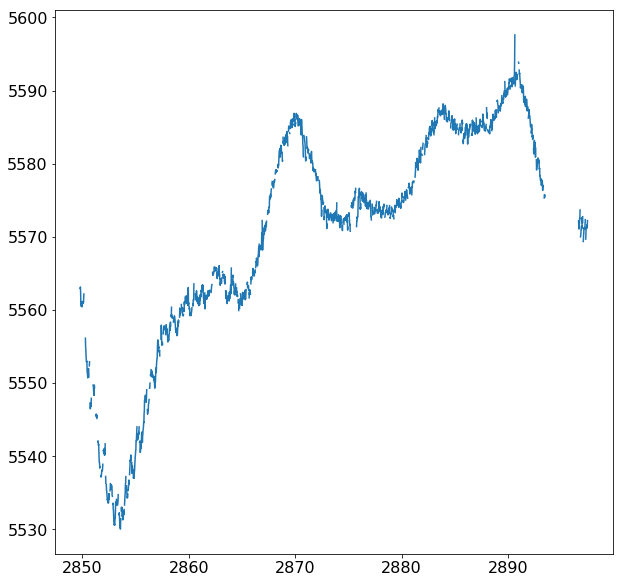

In [6]:
plt.plot(time,lc)

In [7]:
pixelmap.ravel()[mapping] = weights
weightmap = np.ma.array(pixelmap,mask=np.isnan(pixelmap))
norm = np.size(weightmap)


Text(0.5,1,u'TV-min Weightmap for 36 Oph')

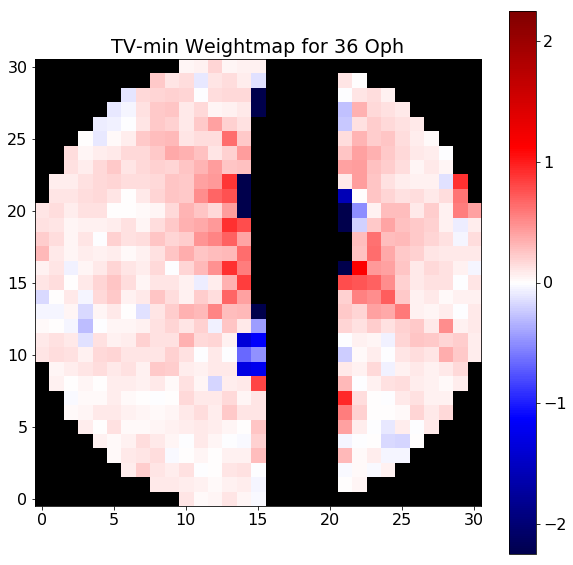

In [8]:
cmap = mpl.cm.seismic
cmap.set_bad('k',1.)
im = np.log10(weightmap.T*norm)
plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
plt.colorbar()
plt.title('TV-min Weightmap for 36 Oph')


In [16]:
hdu = fits.PrimaryHDU(pixelmap.T)
cols = [fits.Column(name=key,format="D",array=ts[key]) for key in ts.keys()]
tab = fits.BinTableHDU.from_columns(cols)

hdul = fits.HDUList([hdu,tab])
hdul.writeto('test.fits',overwrite=True)


In [12]:
hdu

### So now let's check whether we can straightforwardly load in a separate copy of 36 Oph and transfer the weights

In [22]:
fname2 = '../data/ktwo200147465-c112_spd-targ.fits.gz'

In [30]:
%%time
tpff, tss = read_tpf(fname2)
pixelvector, tss2, mapping = censor_tpf(tpff,tss,thresh=thresh,minflux=minflux)

lc_opt_2 = np.dot(weights.T,pixelvector)
lc2 = np.nan*np.ones(len(tss['time']))
lc2[tss['quality']==0] = lc_opt_2
time = tss2['time']

CPU times: user 52 s, sys: 23.8 s, total: 1min 15s
Wall time: 1min 16s


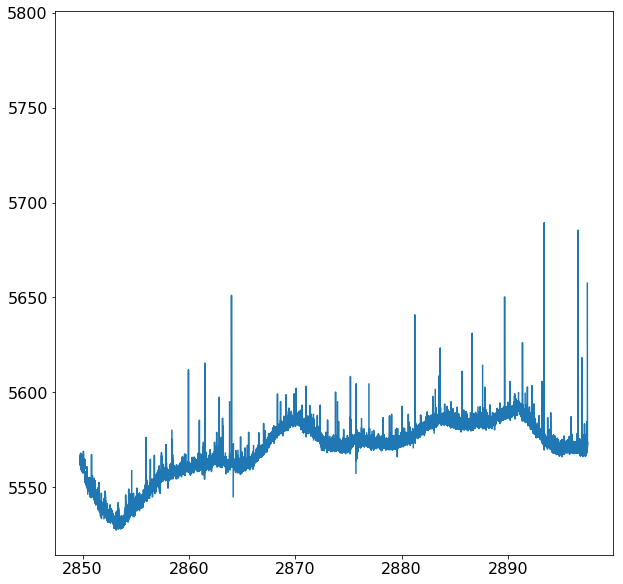

In [35]:
plt.plot(tss['time'],lc2)

## Now let's directly do the optimization on the short cadence data themselves

In [32]:
%%time
weights_short, opt_lc_short = tv_tpf(pixelvector,order=order,maxiter=maxiter,
    w_init=w_init,analytic=analytic,sigclip=False)


Using Analytic Derivatives
CPU times: user 53.8 s, sys: 30.1 s, total: 1min 23s
Wall time: 1min 13s


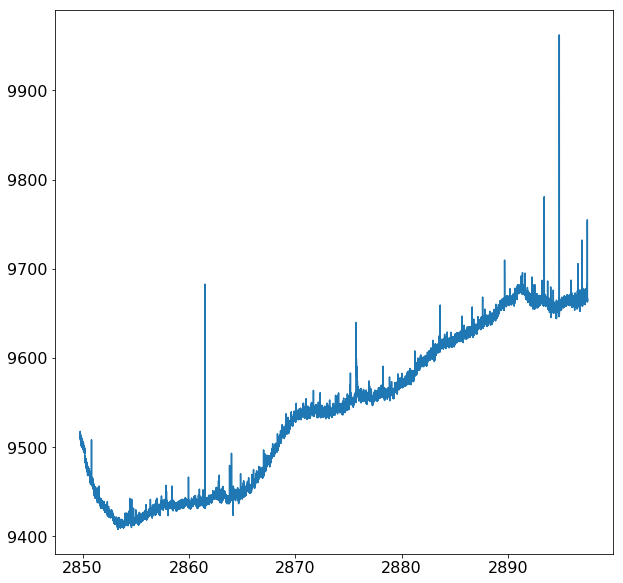

In [36]:
plt.plot(tss2['time'],opt_lc_short)

In [37]:
%%time
weights_short_clip, opt_lc_short_clip = tv_tpf(pixelvector,order=order,maxiter=maxiter,
    w_init=w_init,analytic=analytic,sigclip=True)


Using Analytic Derivatives
Sigma clipping
Clipping 0 bad points
CPU times: user 1min 46s, sys: 1min 1s, total: 2min 47s
Wall time: 2min 26s


In [53]:
opt_lc_short_clip /= np.nanmedian(opt_lc_short_clip)

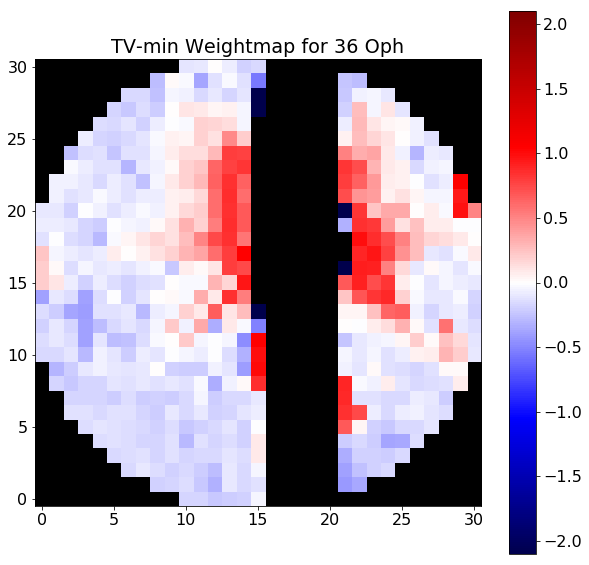

In [180]:
pixelmapsc = np.zeros((tpf.shape[2],tpf.shape[1]))
pixelmapsc.ravel()[mapping] = weights_short_clip
weightmap = np.ma.array(pixelmapsc,mask=np.isnan(pixelmapsc))
norm = np.size(weightmap)

cmap = mpl.cm.seismic
cmap.set_bad('k',1.)
im = np.log10(weightmap.T*norm)
plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
plt.colorbar()
plt.title('TV-min Weightmap for 36 Oph');


## Can we do a quick and not very good SFF style removal of thruster firings?

In [205]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
pca.fit(np.array([xx,yy]).T)
X_pca = pca.transform(np.array([xx,yy]).T)
xxn,yyn = X_pca[:,0], X_pca[:,1] 

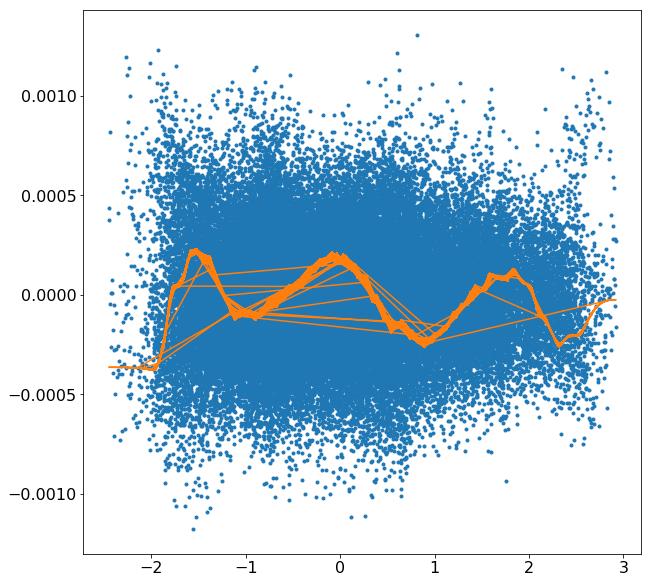

In [258]:
plt.plot(xxn,y-fit[np.argsort(args)],'.')
args = np.argsort(xxn)
fit = gaussian_filter(y[args],100)

plt.plot(xxn,fit[np.argsort(args)],'-')
# plt.plot(yyn,y,'.')

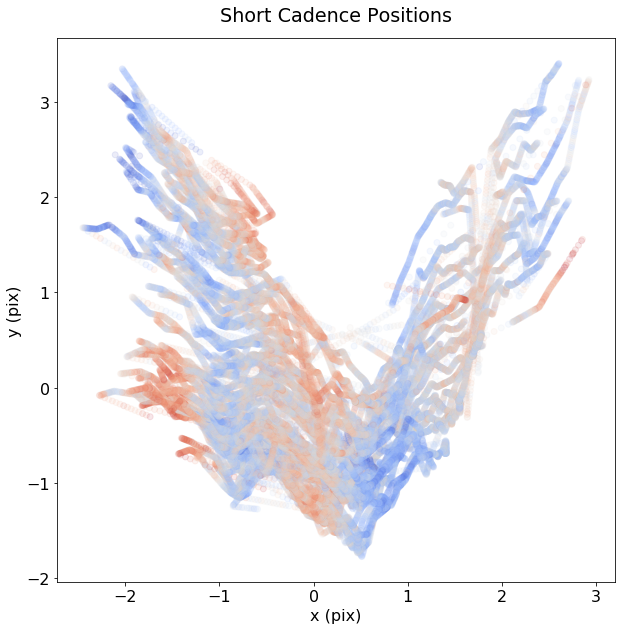

In [210]:
good = tss['quality']==0
xx, yy = tss['x'][good][~outliers][1000:],tss['y'][good][~outliers][1000:]
plt.scatter(xxn,yyn,c=y,alpha=0.1,cmap=mpl.cm.coolwarm)
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.title('Short Cadence Positions',y=1.02);

Find outliers...

CPU times: user 194 ms, sys: 2.2 ms, total: 197 ms
Wall time: 195 ms


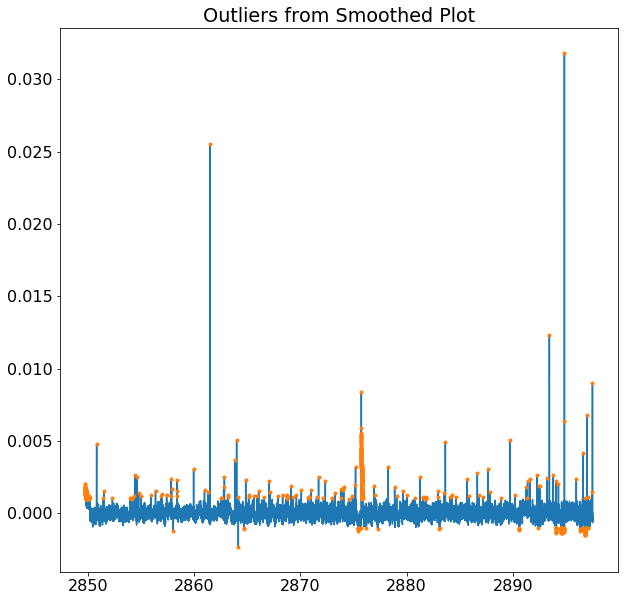

In [181]:
%%time

# smooth = NIF(opt_lc_short_clip,700,55)
smooth = gaussian_filter(opt_lc_short_clip,500)
outliers = np.abs(opt_lc_short_clip-smooth)>0.001
# plt.plot(tss2['time'],opt_lc_short_clip)
# plt.plot(tss2['time'],smooth)

plt.plot(tss2['time'],opt_lc_short_clip-smooth)
plt.plot(tss2['time'][outliers],(opt_lc_short_clip-smooth)[outliers],'.')
plt.title('Outliers from Smoothed Plot')


In [182]:
# plt.plot(t,y,'.')

In [183]:
smooth2 = gaussian_filter(opt_lc_short_clip,500)
# plt.plot(smooth2)

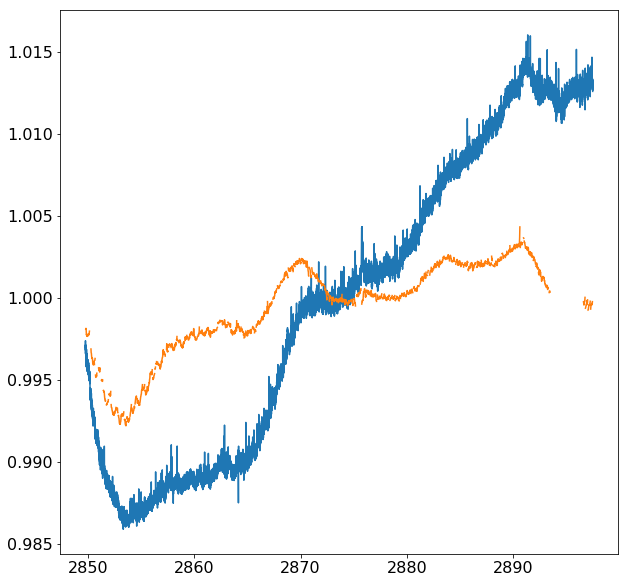

In [59]:
plt.plot(tss2['time'][~outliers],opt_lc_short_clip[~outliers])
plt.plot(ts['time'],lc/np.nanmedian(lc))

## What does a Lomb-Scargle periodogram of this look like?

In [25]:
from astropy.stats import LombScargle

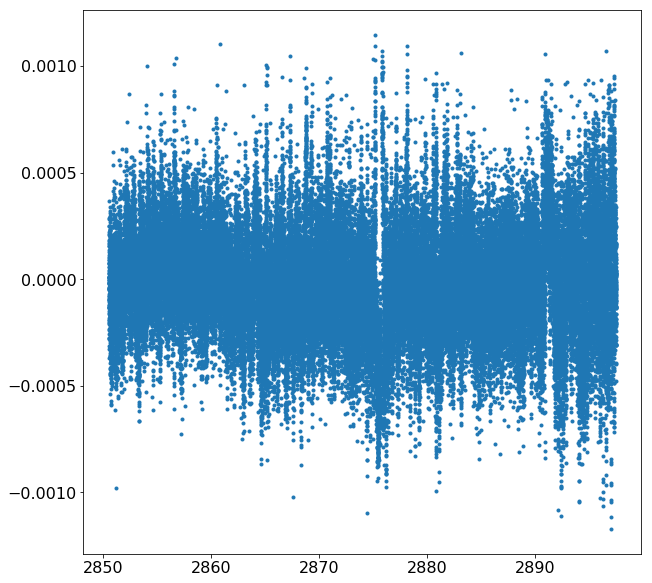

In [259]:
t = tss2['time'][~outliers][1000:]
y = opt_lc_short_clip[~outliers][1000:]-smooth[~outliers][1000:]
y -= fit[np.argsort(args)]
plt.plot(t,y,'.')

In [260]:
%%time 

# get Nyquist: minutes in one day = 60*24 = 1440
# frequency = np.linspace(0.05, 1440/2., 20000)
frequency = np.logspace(np.log10(0.05),np.log10(1440/2.),10000)
power = LombScargle(t, y, np.std(y)/100.).power(frequency)

CPU times: user 36.5 s, sys: 55.3 ms, total: 36.6 s
Wall time: 36.6 s


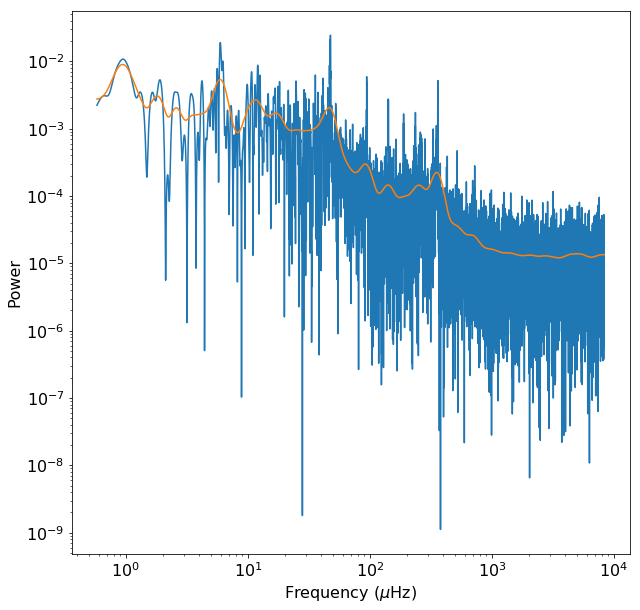

In [261]:
plt.plot(frequency*11.57,power)
plt.plot(frequency*11.57,gaussian_filter(power,100))
plt.xlabel(r'Frequency ($\mu$Hz)')
# plt.xlabel(r'Frequency ($c/d$)')
plt.ylabel('Power')
plt.xscale('log')
plt.yscale('log')
# for j in range(10):
#     plt.axvline(4*11.57*j,color=colours[2],alpha=0.5) # thruster firings

### Not a very clear detection of solar-like oscillations at all - just get some thruster firings.